In [2]:
import pandas as pd
import numpy as np
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
file_path = "/Users/wangshuaibo/Library/CloudStorage/OneDrive-bsu.edu.cn/Archive/文件_XsensMVN输出文档/XsensMTw_ExampleData.txt"

In [4]:
df = pd.read_csv(file_path,skiprows=12,sep="\t")
df.columns

Index(['PacketCounter', 'Year', 'Month', 'Day', 'Second', 'UTC_Nano',
       'UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute',
       'UTC_Second', 'UTC_Valid', 'Acc_X', 'Acc_Y', 'Acc_Z', 'FreeAcc_E',
       'FreeAcc_N', 'FreeAcc_U', 'AccHR_X', 'AccHR_Y', 'AccHR_Z', 'Gyr_X',
       'Gyr_Y', 'Gyr_Z', 'GyrHR_X', 'GyrHR_Y', 'GyrHR_Z', 'Mag_X', 'Mag_Y',
       'Mag_Z', 'VelInc_X', 'VelInc_Y', 'VelInc_Z', 'OriInc_q0', 'OriInc_q1',
       'OriInc_q2', 'OriInc_q3', 'Quat_q0', 'Quat_q1', 'Quat_q2', 'Quat_q3',
       'Roll', 'Pitch', 'Yaw', 'Mat[1][1]', 'Mat[2][1]', 'Mat[3][1]',
       'Mat[1][2]', 'Mat[2][2]', 'Mat[3][2]', 'Mat[1][3]', 'Mat[2][3]',
       'Mat[3][3]', 'Latitude', 'Longitude', 'Altitude', 'Vel_E', 'Vel_N',
       'Vel_U', 'GyrTemp_X', 'GyrTemp_Y', 'GyrTemp_Z'],
      dtype='object')

## 欧拉角转为旋转矩阵

In [5]:
from numpy import cos as cos
from numpy import sin as sin
def euler2matrix(phi,theta,psi):
    '''
    功能：
    根据欧拉角计算旋转矩阵

    参数：
    phi: 围绕 X 轴旋转的角度
    theta: 围绕 Y 轴旋转角度
    psi: 围绕 Z 轴旋转角度
    单位为 度

    返回: 
    旋转矩阵
    旋转矩阵的顺序为：mat11,mat12,mat13, mat21, mat22, mat23, mat31,mat32,mat33
    '''
    phi_rad = np.deg2rad(phi)
    theta_rad = np.deg2rad(theta)
    psi_rad = np.deg2rad(psi)

    mat11 = cos(theta_rad)*cos(psi_rad)
    mat12 = sin(phi_rad)*sin(theta_rad)*cos(psi_rad) - cos(phi_rad)*sin(psi_rad)
    mat13 = cos(phi_rad)*sin(theta_rad)*cos(psi_rad) + sin(phi_rad)*sin(psi_rad)

    mat21 = cos(theta_rad)*sin(psi_rad)
    mat22 = sin(phi_rad)*sin(theta_rad)*sin(psi_rad) + cos(phi_rad)*cos(psi_rad)
    mat23 = cos(phi_rad)*sin(theta_rad)*sin(psi_rad) - sin(phi_rad)*cos(psi_rad)

    mat31 = -sin(theta_rad)
    mat32 = sin(phi_rad)*cos(theta_rad)
    mat33 = cos(phi_rad)*cos(theta_rad) 

    matrix = np.array([mat11,mat12,mat13,
             mat21, mat22, mat23,
             mat31,mat32,mat33])
    return matrix.tolist()

In [6]:
matrix_xsens = ['Mat[1][1]','Mat[1][2]','Mat[1][3]',
                'Mat[2][1]','Mat[2][2]','Mat[2][3]',
                'Mat[3][1]','Mat[3][2]','Mat[3][3]']
euler_xsens = ['Roll', 'Pitch', 'Yaw']
free_acc_xsens = ['FreeAcc_E','FreeAcc_N', 'FreeAcc_U']

<Axes: >

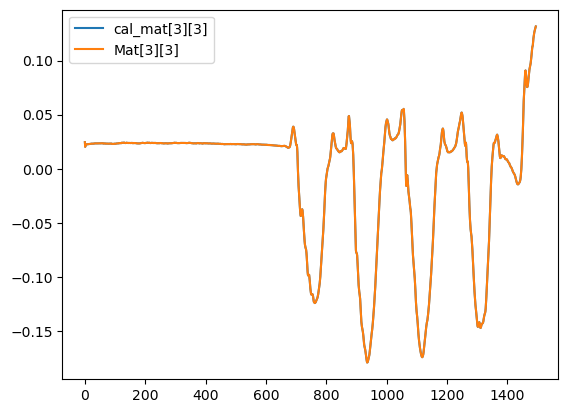

In [7]:
cal_matrixs = []
for i,row in df.iterrows():
    matrix = euler2matrix(row["Roll"],row["Pitch"],row["Yaw"])
    cal_matrixs.append(matrix)
cal_mat_name = ['cal_mat[1][1]','cal_mat[1][2]','cal_mat[1][3]',
            'cal_mat[2][1]','cal_mat[2][2]','cal_mat[2][3]',
            'cal_mat[3][1]','cal_mat[3][2]','cal_mat[3][3]']
df[cal_mat_name] = pd.DataFrame(cal_matrixs)
df[['cal_mat[3][3]','Mat[3][3]']].plot()

In [10]:
# 向量化操作优化操作
roll = df["Roll"].values
pitch = df["Pitch"].values
yaw = df["Yaw"].values

cal_matrixs = [euler2matrix(r, p, y) for r, p, y in zip(roll, pitch, yaw)]

## 计算自由加速度

# 计算自由加速度

In [42]:
# 定义变量
# df.values 可以让一列数据当作一个数据进行运行
mat11 = df["Mat[1][1]"].values
mat12 = df["Mat[1][2]"].values
mat13 = df["Mat[1][3]"].values

mat21 = df["Mat[2][1]"].values
mat22 = df["Mat[2][2]"].values
mat23 = df["Mat[2][3]"].values

mat31 = df["Mat[3][1]"].values
mat32 = df["Mat[3][2]"].values
mat33 = df["Mat[3][3]"].values

Acc_x = df["Acc_X"].values
Acc_y = df["Acc_Y"].values
Acc_z = df["Acc_Z"].values


<class 'numpy.ndarray'>


验证结果：通过✅
计算得到的自由加速度与Xsens 加速度略有差异。
根据 Xsens Dot 可知，Xsens 对直接计算的结果进行了滤波处理。


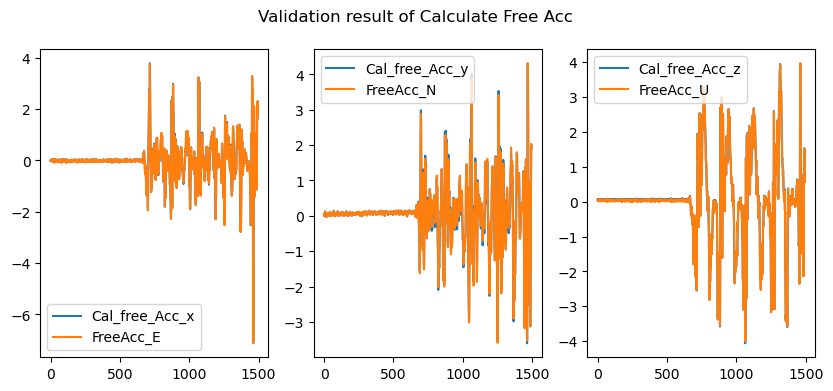

In [40]:
# 计算自由加速度
import numpy as np
import matplotlib.pyplot as plt

# 定义自由加速度函数
def calFreeAcc(mat11,mat12,mat13,mat21,mat22,mat23,mat31,mat32,mat33,Acc_x,Acc_y,Acc_z,g=9.8):
    matrix = np.array([[mat11,mat12,mat13],
                        [mat21,mat22,mat23],
                        [mat31,mat32,mat33]])
    Acc = np.array([Acc_x,Acc_y,Acc_z])
    # 1. 将传感器加速度转换到大地坐标系
    local_acc_transformed = np.dot(matrix,Acc) 
    # 2. 去除重力
    free_acc = local_acc_transformed - np.array([0,0,g])
    return free_acc

#进行计算
free_acc_transformed = [calFreeAcc(mat11,mat12,mat13,mat21,mat22,mat23,mat31,mat32,mat33,Acc_x,Acc_y,Acc_z) for [mat11,mat12,mat13,mat21,mat22,mat23,mat31,mat32,mat33,Acc_x,Acc_y,Acc_z] in zip(mat11,mat12,mat13,mat21,mat22,mat23,mat31,mat32,mat33,Acc_x,Acc_y,Acc_z)]
df[["Cal_free_Acc_x","Cal_free_Acc_y","Cal_free_Acc_z"]] = free_acc_transformed # 不使用 pd.DataFrame(free_acc_tranformed) 其就是 DataFrame

#df[["Cal_free_Acc_z","FreeAcc_U"]].plot()

# 同时绘制Xsens 自由加速度以及计算得到的加速度
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(10,4))
plt.suptitle("Validation result of Calculate Free Acc")
df[["Cal_free_Acc_x","FreeAcc_E"]].plot(ax=axs[0])
df[["Cal_free_Acc_y","FreeAcc_N"]].plot(ax=axs[1])
df[["Cal_free_Acc_z","FreeAcc_U"]].plot(ax=axs[2])

print("验证结果：通过✅")
print("计算得到的自由加速度与Xsens 加速度略有差异。\n"
      "根据 Xsens Dot 可知，Xsens 对直接计算的结果进行了滤波处理。")

In [15]:
df.columns

Index(['PacketCounter', 'Year', 'Month', 'Day', 'Second', 'UTC_Nano',
       'UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute',
       'UTC_Second', 'UTC_Valid', 'Acc_X', 'Acc_Y', 'Acc_Z', 'FreeAcc_E',
       'FreeAcc_N', 'FreeAcc_U', 'AccHR_X', 'AccHR_Y', 'AccHR_Z', 'Gyr_X',
       'Gyr_Y', 'Gyr_Z', 'GyrHR_X', 'GyrHR_Y', 'GyrHR_Z', 'Mag_X', 'Mag_Y',
       'Mag_Z', 'VelInc_X', 'VelInc_Y', 'VelInc_Z', 'OriInc_q0', 'OriInc_q1',
       'OriInc_q2', 'OriInc_q3', 'Quat_q0', 'Quat_q1', 'Quat_q2', 'Quat_q3',
       'Roll', 'Pitch', 'Yaw', 'Mat[1][1]', 'Mat[2][1]', 'Mat[3][1]',
       'Mat[1][2]', 'Mat[2][2]', 'Mat[3][2]', 'Mat[1][3]', 'Mat[2][3]',
       'Mat[3][3]', 'Latitude', 'Longitude', 'Altitude', 'Vel_E', 'Vel_N',
       'Vel_U', 'GyrTemp_X', 'GyrTemp_Y', 'GyrTemp_Z', 'cal_mat[1][1]',
       'cal_mat[1][2]', 'cal_mat[1][3]', 'cal_mat[2][1]', 'cal_mat[2][2]',
       'cal_mat[2][3]', 'cal_mat[3][1]', 'cal_mat[3][2]', 'cal_mat[3][3]',
       'Cal_free_Accx', 'Cal_free_Accy', '

In [92]:
# 获取第 800 行的旋转矩阵
matrix_800 = df[matrix_xsens].loc[800]
matrix_33_800 = np.array(matrix_800).reshape(3,3)

In [95]:
# 计算自由加速度
np.dot(matrix_33_800,df[['Acc_X', 'Acc_Y', 'Acc_Z']].loc[800])

array([ 1.02103052, -0.20560013,  9.25991654])

In [96]:
print("第800行的自由加速度为\n",df[free_acc_xsens].loc[800])

第800行的自由加速度为
 FreeAcc_E    1.055726
FreeAcc_N   -0.075794
FreeAcc_U   -0.555010
Name: 800, dtype: float64


# 尝试批量计算四元数

In [33]:
import pandas as pd
import numpy as np
from pyquaternion import Quaternion

df = pd.DataFrame({"roll":[30,60,90],
                   "pitch":[40,70,100],
                   "yaw":[50,70,110]
})

from scipy.spatial.transform import Rotation as R
# 使用列表接受元素
quaternions = []
for i,row in df.iterrows():
    r = R.from_euler("zyx", [row['roll'], row['pitch'],row['yaw']],degrees=True )
    # 将数组转化成列表
    rotation = r.as_quat().tolist()  
    quaternions.append(rotation)
# 将列表转换为 DataFrame               
df[["q1","q2","q3","q0"]] = pd.DataFrame(quaternions)
df[["q1","q2","q3","q0"]]

,q1,q2,q3,q0
0,0.463827,0.196628,0.360042,0.785221
1,0.641822,0.171976,0.620419,0.416617
2,0.683013,-0.061628,0.704416,-0.183013


In [34]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation

# 定义函数，将欧拉角转换为四元数
def euler_to_quaternion(row):
    r = R.from_euler("zyx", [row['roll'], row['pitch'], row['yaw']], degrees=True)
    return r.as_quat()

# 创建示例 DataFrame
df = pd.DataFrame({"roll": [30, 60, 90], "pitch": [40, 70, 100], "yaw": [50, 70, 110]})

# 使用 apply() 方法将欧拉角转换为四元数，并将结果添加到 DataFrame 中
df[['q1', 'q2', 'q3', 'q0']] = df.apply(euler_to_quaternion, axis=1, result_type='expand')

# 输出结果
print(df)

   roll  pitch  yaw        q1        q2        q3        q0
0    30     40   50  0.463827  0.196628  0.360042  0.785221
1    60     70   70  0.641822  0.171976  0.620419  0.416617
2    90    100  110  0.683013 -0.061628  0.704416 -0.183013
